# Check STAC Item

In [1]:
import os
import pystac
from loguru import logger

def get_asset(item, common_name):
    """Returns the asset of a STAC Item defined with its common band name"""
    for _, asset in item.get_assets().items():
        if not "data" in asset.to_dict()["roles"]:
            continue

        eo_asset = pystac.extensions.eo.AssetEOExtension(asset)
        if not eo_asset.bands:
            continue
        for b in eo_asset.bands:
            if (
                "common_name" in b.properties.keys()
                and b.properties["common_name"] == common_name
            ):
                return asset

In [2]:
dir = 'out_v1.0.23/'
catalog = os.path.join(dir)

In [3]:
if os.path.isdir(dir):
    catalog = pystac.read_file(os.path.join(dir, "catalog.json"))
    item = next(catalog.get_items())

logger.info(f"Read {item.id} from {item.get_self_href()}")

# asset = get_asset(item, band)
# logger.info(f"Read asset {band} from {asset.get_absolute_href()}")

2025-07-10 13:18:02.195 | INFO     | __main__:<module>:5 - Read result-item from /workspace/OpenSarToolkit_sv/resources/out_v1.0.23/result-item/result-item.json


In [4]:
item

<Item id=result-item>

In [5]:
item.validate()

['https://schemas.stacspec.org/v1.1.0/item-spec/json-schema/item.json']

# Create COG

In [6]:
import rasterio
import numpy as np
import os
from rasterio.enums import Resampling
from rasterio.shutil import copy  # this copies and converts to COG format

import matplotlib.pyplot as plt

In [10]:
def rasterio_save(result_array: np.ndarray, profile, outfile_name, transparency_indexes=None, dtype=rasterio.uint8):
    """
    Saves an array as a Cloud-Optimized GeoTIFF (COG) using rasterio.
    """
    factors = [2, 4, 8, 16, 32, 64]
    
    if transparency_indexes is not None:
        result_array[transparency_indexes] = 0
    
    with rasterio.Env():
        profile.update(dtype=dtype, 
                       count=result_array.shape[0], 
                       compress="deflate", 
                       tiled=True, 
                       blockxsize=256, 
                       blockysize=256,
                       driver='GTiff', 
                       BIGTIFF='IF_NEEDED',
                       nodata=0)
        
        temp_file = outfile_name.replace('.tif', '_temp.tif')
        
        try:
            with rasterio.open(temp_file, "w", **profile) as dst:
                dst.write(result_array.astype(dtype))  # writes all bands
                dst.build_overviews(factors, Resampling.nearest)
                dst.update_tags(ns='rio_overview', resampling='nearest')
                
            copy(temp_file, outfile_name, copy_src_overviews=True, driver='COG', compress="deflate")
        finally:
            if os.path.exists(temp_file):
                os.remove(temp_file)
                

In [11]:
def plotBand(array,band):
    plt.figure()
    plt.imshow(array[band,1000:3000,2500:5000])
    plt.show()

In [12]:
# Step 1: Read the input .tif file
input_file = "/workspace/OpenSarToolkit_sv/resources/out_v1.0.23/result-item/20241113.tif"

with rasterio.open(input_file) as src:
    array = src.read()  # Read array
    profile = src.profile  # Get the metadata profile

# Update profile to correct band count
profile.update(count=array.shape[0])  # number of bands

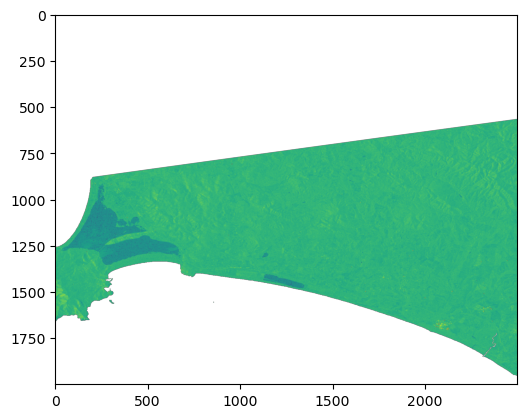

In [13]:
plotBand(array,band=0)

In [14]:
output_file = input_file[:-4] + '_cog.tif'
output_file

'/workspace/OpenSarToolkit_sv/resources/out_v1.0.23/result-item/20241113_cog.tif'

In [15]:
# Optional: Define transparency indexes if needed, e.g., set no-data pixels to 255
transparency_indexes = np.isnan(array)

# Step 2: Call rasterio_save to generate a COG
rasterio_save(array, profile, output_file, transparency_indexes)
print(f'COG file saved: {output_file}')

COG file saved: /workspace/OpenSarToolkit_sv/resources/out_v1.0.23/result-item/20241113_cog.tif
